In [1]:
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.stats import norm
keras = tf.keras
import utils 
from importlib import reload 
print(tf.__version__)

2.3.0


In [2]:
N = 100 # time disrectization    
m = 1 # dimension of price
S0 = 1.0 # initial value of the asset
T = 1 # maturity
strike = 1.0
  
option_type = 'eurocall'
# option_type = 'eurodigitalcall'

if option_type == 'eurocall':
    payoff_function = lambda x : 0.5*(np.abs(x-strike)+x-strike) # European call option payoff
if option_type == 'eurodigitalcall':
    payoff_function = lambda x : (x-strike) > 0 # European digital call option payoff

### Generate Heston paths

The price of the asset $S_t$ is determined by a stochastic process:

$$
dS_{t}=\mu S_{t}\,dt+{\sqrt  {\nu_{t}}}S_{t}\,dW_{t}^{S}
$$

The instantaneous variance $\nu_t$ is a CIR process:

$$
d\nu_{t}=\kappa (\theta -\nu_{t})\,dt+\xi {\sqrt  {\nu_{t}}}\,dW_{t}^{{\nu }}
$$

Feller condition

$$
2\kappa \theta >\xi ^{2}
$$


The sample paths of S are generated by (exact) sampling from the transition density
of the CIR process (see [Gla04, Section 3.4]) and then using the (simplified)
Brodie-Kaya scheme (see [LBAK10] and [BK06]).5 

In [3]:
import QuantLib as ql
# parameters for Heston
# kappa = 1  # mean reversion strength
# sigma = 2  # vol of vol
# rho = -0.7  # corr between asset price and var
# theta = 0.04

kappa = 0.1  # mean reversion strength
sigma = 0.1  # vol of vol
rho = -0.75  # corr between asset price and var
theta = 0.2

vol = theta # historical vols for the stock  
v0 = vol*vol # spot variance

print(2*kappa*theta - sigma**2)

0.030000000000000006


In [4]:


day_count = ql.Actual365Fixed()

calculation_date = ql.Date(1, 10, 2020)
spot_price = 1.00
# ql.Settings.instance().evaluationDate = calculation_date

# construct the yield curve
dividend_rate =  0
risk_free_rate = 0
flat_ts = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, risk_free_rate, day_count)
)
dividend_yield = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, dividend_rate, day_count)
)

# set the spot price
spot_handle = ql.QuoteHandle(
    ql.SimpleQuote(spot_price)
)

# calculate option price
heston_process = ql.HestonProcess(
flat_ts, dividend_yield, spot_handle,
v0, kappa, theta, sigma, rho
)


timestep = 100
length = 1
times = ql.TimeGrid(length, timestep)
dimension = heston_process.factors()
Ktrain = 10**5

rng = ql.UniformRandomSequenceGenerator(dimension * timestep, ql.UniformRandomGenerator())
sequenceGenerator = ql.GaussianRandomSequenceGenerator(rng)
pathGenerator = ql.GaussianMultiPathGenerator(heston_process, list(times), sequenceGenerator, False)

# paths[0] will contain spot paths, paths[1] will contain vol paths
paths = [[] for i in range(dimension)]
for i in range(Ktrain):
    samplePath = pathGenerator.next()
    values = samplePath.value()
    spot = values[0]

    for j in range(dimension):
        paths[j].append([x for x in values[j]])
        
        
price_path, vol_path = np.array(paths)[0,:,:], np.array(paths)[1,:,:]
price_path = price_path[:,:,None]
vol_path = vol_path[:,:,None]

payoff = payoff_function(price_path[:,-1]) 
price_path1 = np.concatenate([price_path, vol_path],axis = -1)

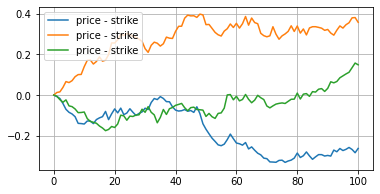

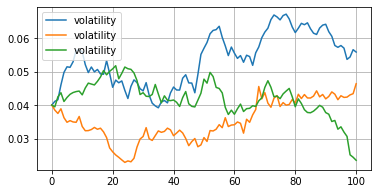

In [5]:

plt.figure(figsize = [6,3])
plt.plot(price_path[:3,:,0].T - S0, label = 'price - strike')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize = [6,3])
plt.plot(vol_path[:3,:,0].T, label = 'volatility')
plt.legend()
plt.grid()
plt.show()

### Build the deep hedging dynamic 

Value process
$$
V_{t} = \int_{0}^{t}H_{t}dS_{t} + \alpha \int_{0}^{t}(S_{t}dH_{t})^{2} \cdot \text{(trans_cost =True)}
$$
Objective function
\begin{equation}
\begin{split}
\min_{H_{t}}\quad & E\bigg[(f(S_{T})-V_{T})^2\bigg] \\
+ &\beta E\bigg[\int_{0}^{T}(C_{t} - V_{t})^{2}dt\bigg] \cdot \text{(control_path =True)}\\
+ &\alpha E\bigg[\int_{0}^{t}(S_{t}dH_{t})^{2}\bigg] \cdot \text{(control_trans_cost =True)}
\end{split}
\end{equation}

where $(C_{t})_{t\geq 0}$ is the call option price and $f$ is the payoff function.

In [6]:
def build_dynamic(m, N, control_path, control_trans_cost, trans_cost):
    
    d = 3 # number of layers in strategy
    n = 32  # nodes in the first but last layers
    Networks = utils.build_network(m, n , d, N)
    Network0 = keras.layers.Dense(m, use_bias=False)
    
    # Non-recurrent structure

    price = keras.Input(shape=(N+1,m))   # S_{t}; t=0,..,N+1; (batch, N+1, m)
    benchmark_hedge = keras.Input(shape=(N+1,m))   # V_{t}; t=0,..,N+1; (batch, N+1, m)
    if control_path:
        inputs = [price,benchmark_hedge]
    else:
        inputs = price
    price_difference = price[:,1:,:] - price[:,:-1,:]  # dS_{t}; t=0,..,N; (batch, N, m)
    premium = Network0(tf.ones_like(price[:,0,:])) # premium; (batch, m)
    HEDGE = [None]*(N+1)
    HEDGE[0] = tf.zeros_like(price[:,0,:])
    STRATEGY = [None]*N
    for j in range(N):
        STRATEGY[j] = Networks[j](tf.math.log(price[:,j,:])) # H_{t} = nn(S_{t}); (batch, m)
        cost = 0
        if trans_cost: 
            if j > 0:
                cost = 0.005*((STRATEGY[j]- STRATEGY[j-1])*price[:,j,:])**2
        HEDGE[j+1] = HEDGE[j] + STRATEGY[j] * price_difference[:,j,:] - cost # dX_{t} = H_{t}dS_{t}; (batch, m)
    outputs = premium + HEDGE[-1] # premium + \int_{0}^{T}H_{t}dS_{t}; (batch, m)
    model_hedge = keras.Model(inputs = inputs, outputs=outputs)
    if control_path:
        for j in range(N):
            mse = tf.keras.losses.MeanSquaredError()
            model_hedge.add_loss(10*mse(HEDGE[j]+premium, benchmark_hedge[:,j])) 
    if control_trans_cost:
        for j in range(N):
            if j > 0:
                model_hedge.add_loss(0.005*mse(STRATEGY[j]*price[:,j,:], STRATEGY[j-1]*price[:,j,:]))
                
    return model_hedge 


In [7]:
model_hedge = build_dynamic(m, N, False, False, False)

### Train the model

In [11]:
control_path = False
if not control_path:
    option_path = price_path
split = int(Ktrain/2)
xtrain = [price_path[:split],option_path[:split]]  # input be price_path
ytrain = payoff[:split]  # output be payoff
xtest = [price_path[split:],option_path[split:]]  # input be price_path
ytest = payoff[split:]  # output be payoff

In [12]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01) # specify the optmizer 
model_hedge.compile(optimizer = optimizer,loss='mse') # specify the mean square loss 
# model_hedge.compile(optimizer = optimizer,loss=custom_mean_squared_error) # specify the mean square loss 
model_hedge.fit(x=xtrain,y=ytrain, epochs=10,verbose=True,batch_size=1000) # train the model 

Epoch 1/10
50/50 [==============================] - 1s 23ms/step - loss: 1.1071
Epoch 2/10
50/50 [==============================] - 1s 23ms/step - loss: 0.3915
Epoch 3/10
50/50 [==============================] - 1s 22ms/step - loss: 0.1068
Epoch 4/10
50/50 [==============================] - 1s 22ms/step - loss: 0.0218
Epoch 5/10
50/50 [==============================] - 1s 22ms/step - loss: 0.0034
Epoch 6/10
50/50 [==============================] - 1s 22ms/step - loss: 5.3727e-04
Epoch 7/10
50/50 [==============================] - 1s 21ms/step - loss: 1.9872e-04
Epoch 8/10
50/50 [==============================] - 1s 21ms/step - loss: 1.5592e-04
Epoch 9/10
50/50 [==============================] - 1s 22ms/step - loss: 1.4375e-04: 0s - lo
Epoch 10/10
50/50 [==============================] - 1s 21ms/step - loss: 1.3704e-04


### Compared with delta hedging 

In [13]:
hedge_output_train = model_hedge.predict(xtrain) # compute the output (deep replicate payoff) with trained model 
hedge_output_test = model_hedge.predict(xtest) # compute the output (deep replicate payoff) with trained model

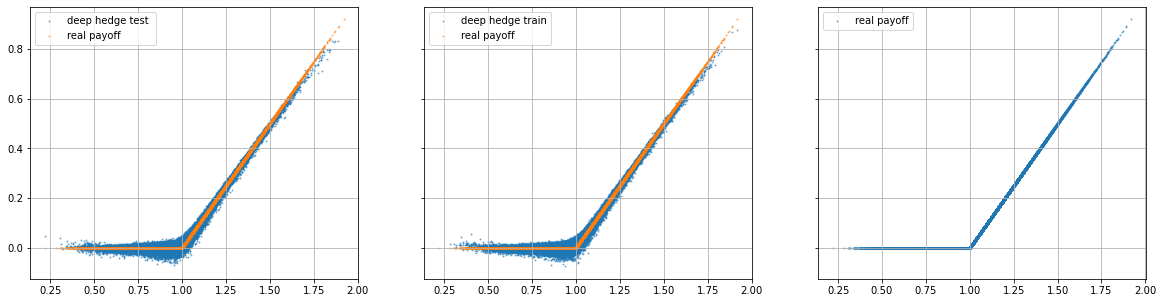

In [14]:
# Only with control path
f,p = plt.subplots(1,3, figsize = [20,5], sharey = True)
p[0].scatter(price_path[split:,-1,0], hedge_output_test[:,0], s = 1, alpha = 0.5, label = 'deep hedge test ')   # deep replicate payoff 
p[1].scatter(price_path[:split,-1,0], hedge_output_train[:,0], s = 1, alpha = 0.5, label = 'deep hedge train')   # deep replicate payoff 
# p[2].scatter(price_path[:,-1,0], delta_output[:,0], s = 1, alpha = 0.5, label = 'delta hedge')   # delta replicate payoff 
for i in range(3):
    p[i].scatter(price_path[:,-1,0], payoff[:,0], s = 1, alpha = 0.5, label = 'real payoff')        # real payoff
    p[i].legend()
    p[i].grid()

In [ ]:
# f,p = plt.subplots(1,5,figsize = [20,5])
# for i in range(5):
#     n = 20*i + 10
#     pr = np.linspace(0.5,2,100)[:,None]  # tf.tensor of different price 

#     he = Networks[n](pr) # the stategy network 
#     p[i].plot(pr[:,0],he[:,0], label = 'deep hedge') # plot the relation between price and deep strategy

#     _,delta = utils.BlackScholes(T - time_grid[n], pr, strike, sigma, option_type)
#     p[i].plot(pr, delta, label = 'delta hedge') # plot the relation between price and delta strategy
#     p[i].title.set_text(f"At time: {time_grid[n]:{1}.{4}}")
#     p[i].legend()
#     p[i].grid()
# plt.show()

In [ ]:
# Hedge = [None] * N
# transaction_cost = 0
# for j in range(N):
#     Hedge[j] = Networks[j](price_path[:,j,:])
#     if j > 0: 
#         transaction_cost += 0.005*(Hedge[j]*price_path[:,j-1,:] - Hedge[j-1]*price_path[:,j-1,:])**2
# print(transaction_cost[:,0].numpy().mean())
# plt.hist(transaction_cost[:,0].numpy())

In [ ]:
# print(f"deep premium: {Network0(tf.ones([1,1])).numpy()[0,0]:{1}.{4}}")         # premium of deep hedge (truncted printing)
# helper,_ = utils.BlackScholes(T, S0, strike, sigma, option_type)
# print(f"real premium: {helper:{1}.{4}}")           # real premium